<a href="https://colab.research.google.com/github/giosumarin/BIS/blob/main/exam_marin%C3%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATALOGS & PM4PY

In [ ]:
!pip install pm4py

In [ ]:
!wget https://raw.githubusercontent.com/giosumarin/BIP/main/data/DomesticDeclarations.xes
!wget https://raw.githubusercontent.com/giosumarin/BIP/main/data/InternationalDeclarations.xes
!wget https://raw.githubusercontent.com/giosumarin/BIP/main/data/PermitLog.xes
!wget https://raw.githubusercontent.com/giosumarin/BIP/main/data/PrepaidTravelCost.xes
!wget https://raw.githubusercontent.com/giosumarin/BIP/main/data/RequestForPayment.xes


In [ ]:
import numpy as np
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

data_folder = "./"

nat_dec      = f'{data_folder}DomesticDeclarations.xes'
int_dec      = f'{data_folder}InternationalDeclarations.xes'
per_log      = f'{data_folder}PermitLog.xes'
pre_tra_cost = f'{data_folder}PrepaidTravelCost.xes'
req_4_pay    = f'{data_folder}RequestForPayment.xes'

list_xes = [nat_dec, int_dec, per_log, pre_tra_cost, req_4_pay]
list_name = ["nat_dec", "int_dec", "per_log", "pre_tra_cost", "req_4_pay"]



def get_logs(xes_file):
    return xes_importer.apply(xes_file)


def log_to_df(log):
    return log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

def df_to_log(df):
    return log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)


In [ ]:
d_log = {n:get_logs(f) for n,f in zip(list_name, list_xes)}

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/7065 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/2099 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6886 [00:00<?, ?it/s]

In [ ]:
original_cases = {k:len(d_log[k]) for k in d_log.keys()}
original_cases

{'int_dec': 6449,
 'nat_dec': 10500,
 'per_log': 7065,
 'pre_tra_cost': 2099,
 'req_4_pay': 6886}

In [ ]:
d_df = {k:log_to_df(d_log[k]) for k in d_log.keys()}

# TEMPORAL FILTERING

In [ ]:
#filtering logs by time as indicated on BIP 2020 challenge(2018 and later)

from pm4py.algo.filtering.log.timestamp import timestamp_filter
d_log = {k:timestamp_filter.filter_traces_contained(d_df[k], "2018-01-01 00:00:00", "2022-01-18 23:59:59",
                parameters={timestamp_filter.Parameters.TIMESTAMP_KEY: "time:timestamp"}) for k in d_df.keys()}


In [ ]:
d_df = {k:log_to_df(v) for k,v in d_log.items()}

In [ ]:
#removed cases after time filtering
print({k:(original_cases[k]-len(d_log[k]), len(d_log[k])) for k in d_log.keys()})

{'nat_dec': (2240, 8260), 'int_dec': (1497, 4952), 'per_log': (1467, 5598), 'pre_tra_cost': (323, 1776), 'req_4_pay': (1108, 5778)}


In [ ]:
after_time = {k:len(d_log[k]) for k in d_log.keys()}
after_time

{'int_dec': 4952,
 'nat_dec': 8260,
 'per_log': 5598,
 'pre_tra_cost': 1776,
 'req_4_pay': 5778}

# ROLES ANALYSIS

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data = [15, 25, 25, 30, 5]
labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']


def sea_pie(data, labels):
    colors = sns.color_palette('pastel')[0:5]
    plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    plt.show()


In [ ]:
res = []

for k, v in d_df.items():
    tmp = v['org:role'].value_counts()
    res.append(tmp)

dict_res = {}
for r in res:
    for role in r.index:
        if role in dict_res.keys():            
            dict_res[role] += r[role]
        else:
            dict_res[role] = r[role]
print(dict_res)

{'UNDEFINED': 53548, 'EMPLOYEE': 71597, 'ADMINISTRATION': 43823, 'SUPERVISOR': 38139, 'BUDGET OWNER': 14255, 'DIRECTOR': 1629, 'MISSING': 4}


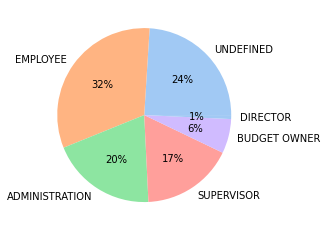

In [ ]:
#remove outlier
dict_res.pop("MISSING")

sea_pie(dict_res.values(), dict_res.keys())


# BOTTLENECK & THROUGHTPUT
#### The idea is to find problems with the travel's management, so some investigation on bottleneck of the process can be interesting.

In [ ]:
import pandas as pd
for s,e in [["Declaration SUBMITTED by EMPLOYEE", "Payment Handled"], 
            ["Request Payment", "Payment Handled"], 
            ["Declaration FINAL_APPROVED by SUPERVISOR", "Request Payment"]]:
  print(s,"-->", e)
  for k in ["nat_dec", "per_log", "int_dec"]:
    list_res = []
    for trace in d_log[k]:
        approve_event = None
        request_event = None
        for event in trace:
            if event['concept:name'] == s:
                approve_event = event['time:timestamp']
            elif event['concept:name'] == e:
                request_event = event['time:timestamp']
                break
        if request_event is not None and approve_event is not None:
            list_res.append((approve_event, request_event, trace.attributes['concept:name']))

    print(k,pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[1])

Declaration SUBMITTED by EMPLOYEE --> Payment Handled
nat_dec 10.351696703900533
per_log 12.177136239563264
int_dec 12.377994023276072
Request Payment --> Payment Handled
nat_dec 3.4502923201269278
per_log 3.454933620882814
int_dec 3.415863424947973
Declaration FINAL_APPROVED by SUPERVISOR --> Request Payment
nat_dec 2.842032531122181
per_log 2.9046599405082767
int_dec 2.8568018781657307


In [ ]:
# Declaration SUBMITTED by EMPLOYEE to Payment Handled


for k in d_log.keys():
    list_res = []
    for trace in d_log[k]:
        start = None
        end = None
        for event in trace:
            if event['concept:name'] == 'Declaration SUBMITTED by EMPLOYEE':
                start = event['time:timestamp']
            elif event['concept:name'] == 'Payment Handled':
                end = event['time:timestamp']
                break
        if start is not None and end is not None:
            list_res.append((start, end, trace.attributes['concept:name']))

    print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%", "max"]])


nat_dec 
 25%      6.052558
50%      7.325440
75%     11.703924
max    290.905498
dtype: float64
int_dec 
 25%      6.266736
50%      9.269363
75%     14.246157
max    429.112824
dtype: float64
per_log 
 25%      6.226962
50%      9.222506
75%     14.224751
max    349.814306
dtype: float64
pre_tra_cost 
 25%   NaN
50%   NaN
75%   NaN
max   NaN
dtype: float64
req_4_pay 
 25%   NaN
50%   NaN
75%   NaN
max   NaN
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
# From Request Payment to Payment Handled
for k in d_log.keys():
    list_res = []
    for trace in d_log[k]:
        approve_event = None
        request_event = None
        for event in trace:
            if event['concept:name'] == 'Request Payment':
                approve_event = event['time:timestamp']
            elif event['concept:name'] == 'Payment Handled':
                request_event = event['time:timestamp']
                break
        if request_event is not None and approve_event is not None:
            list_res.append((approve_event, request_event, trace.attributes['concept:name']))
    #print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["mean"]])
    print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%", "max"]])

#pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()


nat_dec 
 25%     2.319740
50%     3.213819
75%     4.288278
max    62.145127
dtype: float64
int_dec 
 25%     2.316429
50%     3.234728
75%     4.289557
max    29.060984
dtype: float64
per_log 
 25%     2.320394
50%     3.237512
75%     4.295046
max    29.060984
dtype: float64
pre_tra_cost 
 25%     2.345428
50%     3.324896
75%     4.313275
max    27.468935
dtype: float64
req_4_pay 
 25%     2.320362
50%     3.217784
75%     4.283533
max    62.145336
dtype: float64


In [ ]:
# From Declaration FINAL_APPROVED by SUPERVISOR to Request Payment



for k in d_log.keys():
    list_res = []
    for trace in d_log[k]:
        approve_event = None
        request_event = None
        for event in trace:
            if event['concept:name'] == 'Declaration FINAL_APPROVED by SUPERVISOR':
                approve_event = event['time:timestamp']
            elif event['concept:name'] == 'Request Payment':
                request_event = event['time:timestamp']
                break
        if request_event is not None and approve_event is not None:
            list_res.append((approve_event, request_event, trace.attributes['concept:name']))
    #print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["mean"]])
    print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%", "max"]])


#pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()


nat_dec 
 25%      0.296933
50%      1.059670
75%      3.670119
max    105.860197
dtype: float64
int_dec 
 25%      0.261875
50%      1.075156
75%      3.754922
max    266.099039
dtype: float64
per_log 
 25%      0.277946
50%      1.073501
75%      3.834161
max    266.099039
dtype: float64
pre_tra_cost 
 25%   NaN
50%   NaN
75%   NaN
max   NaN
dtype: float64
req_4_pay 
 25%   NaN
50%   NaN
75%   NaN
max   NaN
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
# From Declaration FINAL_APPROVED by SUPERVISOR to Request Payment
for k in d_log.keys():
    list_res = []
    for trace in d_log[k]:
        approve_event = None
        request_event = None
        for event in trace:
            if event['concept:name'] == 'Declaration SUBMITTED by EMPLOYEE':
                approve_event = event['time:timestamp']
            elif event['concept:name'] == 'Declaration APPROVED by ADMINISTRATION':
                request_event = event['time:timestamp']
                break
        if request_event is not None and approve_event is not None:
            list_res.append((approve_event, request_event, trace.attributes['concept:name']))
    #print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["mean"]])
    print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%", "max"]])

#pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()


nat_dec 
 25%      0.000069
50%      0.000475
75%      0.002824
max    282.582558
dtype: float64
int_dec 
 25%      0.000139
50%      0.002176
75%      0.022326
max    422.003970
dtype: float64
per_log 
 25%      0.000139
50%      0.002245
75%      0.024618
max    348.510914
dtype: float64
pre_tra_cost 
 25%   NaN
50%   NaN
75%   NaN
max   NaN
dtype: float64
req_4_pay 
 25%   NaN
50%   NaN
75%   NaN
max   NaN
dtype: float64


/tmp/ipykernel_4190/2537463709.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%", "max"]])
/tmp/ipykernel_4190/2537463709.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%", "max"]])


In [ ]:
# From Declaration FINAL_APPROVED by SUPERVISOR to Request Payment
for k in d_log.keys():
    list_res = []
    for trace in d_log[k]:
        approve_event = None
        request_event = None
        for event in trace:
            if event['concept:name'] == 'Declaration APPROVED by ADMINISTRATION':
                approve_event = event['time:timestamp']
            elif event['concept:name'] == 'Declaration FINAL_APPROVED by SUPERVISOR':
                request_event = event['time:timestamp']
                break
        if request_event is not None and approve_event is not None:
            list_res.append((approve_event, request_event, trace.attributes['concept:name']))
    #print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["mean"]])
    print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%", "max"]])

#pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()


nat_dec 
 25%     0.603854
50%     1.707199
75%     4.152245
max    54.657963
dtype: float64
int_dec 
 25%     0.817124
50%     2.628588
75%     6.305712
max    57.789977
dtype: float64
per_log 
 25%     0.810148
50%     2.598096
75%     6.274635
max    52.824560
dtype: float64
pre_tra_cost 
 25%   NaN
50%   NaN
75%   NaN
max   NaN
dtype: float64
req_4_pay 
 25%   NaN
50%   NaN
75%   NaN
max   NaN
dtype: float64


/tmp/ipykernel_4190/3797959106.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%", "max"]])
/tmp/ipykernel_4190/3797959106.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  print(k,"\n", pd.Series([(end-start).total_seconds()/60/60/24 for (start, end, _) in list_res]).describe()[["25%","50%", "75%", "max"]])


# CHECKING DOUBLE PAYMENTS

In [ ]:
def double_pay(log):
    dict_decl = set()
    res_double = []
    for trace in log:
        for event in trace:
            if event['concept:name'] == 'Payment Handled':
                dec = trace.attributes['concept:name']
                if dec in dict_decl:
                    res_double.append(dec)
                else:
                    dict_decl.add(dec)

    return len(res_double), set(res_double)
for k in d_log.keys():
    r = len(double_pay(d_log[k])[1])
    if r != 0:
        print(f"{k} --> {len(double_pay(d_log[k])[1])}")

per_log --> 1017


In [ ]:
# Start analysis on PermissionLog



set_double = list(double_pay(d_log["per_log"])[1])
res_dict = {k:[] for k in set_double}
for trace in d_log["per_log"]:
    if (trace.attributes["concept:name"]) in set_double:
        for event in trace:
            if event['concept:name'] == 'Payment Handled':
                res_dict[trace.attributes["concept:name"]].append(trace.attributes["TotalDeclared"])
tmp = []
for k, v in res_dict.items():
    tmp.append([k, round(v[0]), len(v)])
df_res = pd.DataFrame(tmp, columns=["ID", "VALUE", "REPETITION"])
df_res["LOSS"] = df_res["VALUE"].to_numpy()*(df_res["REPETITION"].to_numpy()-1)
df_res.sort_values("LOSS", ascending=False).head(10)

,ID,VALUE,REPETITION,LOSS
446,travel permit 54518,1458579,2,1458579
56,travel permit 22776,12232,14,159016
262,travel permit 24054,9246,12,101706
230,travel permit 53343,4811,14,62543
431,travel permit 57181,4652,9,37216
190,travel permit 33319,6177,6,30885
750,travel permit 45672,6626,5,26504
255,travel permit 66595,5043,6,25215
795,travel permit 28756,4133,7,24798
954,travel permit 2501,3842,6,19210


In [ ]:
np.sum(df_res["LOSS"])

4478912

# CHECKING REJECTED DECLARATIONS


In [ ]:
def count_reject(log, set_rejected_events):
    rej = 0
    for trace in log:
        for event in trace:
            if event['concept:name'] in set_rejected_events:
                rej+=1
                break
    return rej    

In [ ]:
#never approved (so no Payment Handled)
def count_never_approved(log):
    rej = 0
    for trace in log:
        tmp_set_events = set()
        for event in trace:
            tmp_set_events.add(event['concept:name'])
        if "Payment Handled" not in tmp_set_events:
            rej+=1

    return rej    

In [ ]:
print("DOMESTIC DECLARATION")
set_rejected_events = {x for x in d_df["nat_dec"]["concept:name"].to_list() if "REJECTED" in x}
rej = count_reject(d_log["nat_dec"], set_rejected_events)
print(f"Traces with rejected status={rej}, Total traces={len(d_log['nat_dec'])}, %traces with rejected={round(rej/len(d_log['nat_dec'])*100,2)}%")

rej = count_never_approved(d_log["nat_dec"])
print(f"Traces never approved={rej}, Total traces={len(d_log['nat_dec'])}, %traces never approved={round(rej/len(d_log['nat_dec'])*100,2)}%")


print("\n\nINTERNATIONAL DECLARATION")
set_rejected_events = {x for x in d_df["int_dec"]["concept:name"].to_list() if "REJECTED" in x}
rej = count_reject(d_log["int_dec"], set_rejected_events)
print(f"Traces with rejected status={rej}, Total traces={len(d_log['int_dec'])}, %traces with rejected={round(rej/len(d_log['int_dec'])*100,2)}%")
rej = count_never_approved(d_log["int_dec"])
print(f"Traces never approved={rej}, Total traces={len(d_log['int_dec'])}, %traces never approved={round(rej/len(d_log['int_dec'])*100,2)}%")


DOMESTIC DECLARATION
Traces with rejected status=1072, Total traces=8260, %traces with rejected=12.98%
Traces never approved=357, Total traces=8260, %traces never approved=4.32%


INTERNATIONAL DECLARATION
Traces with rejected status=1458, Total traces=4952, %traces with rejected=29.44%
Traces never approved=211, Total traces=4952, %traces never approved=4.26%


# VARIANTS ANALYSIS

## TOP 5 VARIANTS

In [ ]:
# keep only top 5 variants, other have some alternative repetitive behavior between rejected and re-submitted

import pm4py
d_log_var = {k:pm4py.filter_variants_top_k(d_log[k], 5) for k in d_log.keys()}

for k,v in d_log_var.items():
    print (f"{k} --> {round(100*(len(v)/len(d_log[k])))}% - {len(v)}")


nat_dec --> 94% - 7786
int_dec --> 53% - 2632
per_log --> 38% - 2135
pre_tra_cost --> 68% - 1199
req_4_pay --> 94% - 5432


## BEST MODELS

In [ ]:
# PROPORRE L'AGGIUNTA IN PM4PY

from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

def metrics(net, im, fm, log):
    fitness = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
    prec = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
    gen = generalization_evaluator.apply(log, net, im, fm)
    simp = simplicity_evaluator.apply(net)
    return round(fitness["perc_fit_traces"],2), round(prec,2), round(gen,2), round(simp,2)

def model_stats(log):
    tmp=[]
    net, im, fm = alpha_miner.apply(log)
    f,p,g,s = metrics(net, im, ## TOP 5 VARIANTSfm, log)
    tmp.append(["Alpha", ["NONE"], f,p,g,s])
    net, im, fm = inductive_miner.apply(log)
    f,p,g,s = metrics(net, im, fm, log)
    tmp.append(["IM", ["NONE"], f,p,g,s])

    for n in range(0, 11):
        NOISE=n/10 
        net, im, fm = inductive_miner.apply(log, variant=inductive_miner.Variants.IMf, parameters={inductive_miner.Variants.IMf:NOISE})
        f,p,g,s = metrics(net, im, fm, log)
        tmp.append(["IMf", [NOISE], f,p,g,s])

    net, im, fm = inductive_miner.apply(log, variant=inductive_miner.Variants.IMd)
    f,p,g,s = metrics(net, im, fm, log)
    tmp.append(["IMd", [], f,p,g,s])

    for dep in range(1, 11, 1):
        for min_act in [1,20,100,200,300]:#range(10,171,20):
            for min_dfg in [1,20,100,200,300]:#range(10,171,20):
                ps = [dep/10, min_act, min_dfg]
                pars = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: ps[0], 
                        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT:ps[1], 
                        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES:ps[2]}
                net, im, fm = heuristics_miner.apply(log, parameters=pars)
                f,p,g,s = metrics(net, im, fm, log)
                tmp.append(["HEU", ps, f,p,g,s])

    return pd.DataFrame(tmp, columns=["MODEL", "PARAMETERS", "FITNESS", "PRECISION", "GENERALIZATION", "SEMPLICITY"])

In [ ]:
res = {}
for k in d_log_var.keys():
    res[k] = model_stats(d_log_var[k])


In [ ]:
def rename(name):
    if name == 'nat_dec':
        return "DomesticDeclaration"
    if name == 'int_dec':
        return "InternationalDeclaration"
    if name == 'per_log':
        return "PermitLog"
    if name == 'pre_tra_cost':
        return "PrepayedTravelCost"
    if name == 'req_4_pay':
        return "RequestForPay"


In [ ]:
for k, v in res.items():
    v["LOG"] = [rename(k)]*len(v)

In [ ]:
tot_res = pd.concat(res.values())

In [ ]:
r = tot_res[(tot_res["FITNESS"]>=92) & (tot_res["PRECISION"]>=.8)]\
    .sort_values(["SEMPLICITY","PRECISION", "GENERALIZATION"], ascending=False)\
        .groupby("LOG").head(1)
r.to_csv("best.csv")
r

,MODEL,PARAMETERS,FITNESS,PRECISION,GENERALIZATION,SEMPLICITY,LOG
2,IMf,[0.0],92.24,0.92,0.96,0.87,PrepayedTravelCost
14,HEU,"[0.1, 1, 1]",100.00,0.99,0.98,0.85,DomesticDeclaration
14,HEU,"[0.1, 1, 1]",100.00,0.99,0.97,0.85,RequestForPay
17,HEU,"[0.1, 1, 200]",94.68,0.92,0.97,0.84,InternationalDeclaration
17,HEU,"[0.1, 1, 200]",92.22,0.89,0.97,0.83,PermitLog


## VISUALIZATION BEST MODELS

In [ ]:
names = ["PrepayedTravelCost","DomesticDeclaration","RequestForPay","InternationalDeclaration","PermitLog"]
pss = {}
for n in names:
    pss[n] = r[r["LOG"]==n]["PARAMETERS"].to_numpy()[0]


In [ ]:
dict_nets = {}

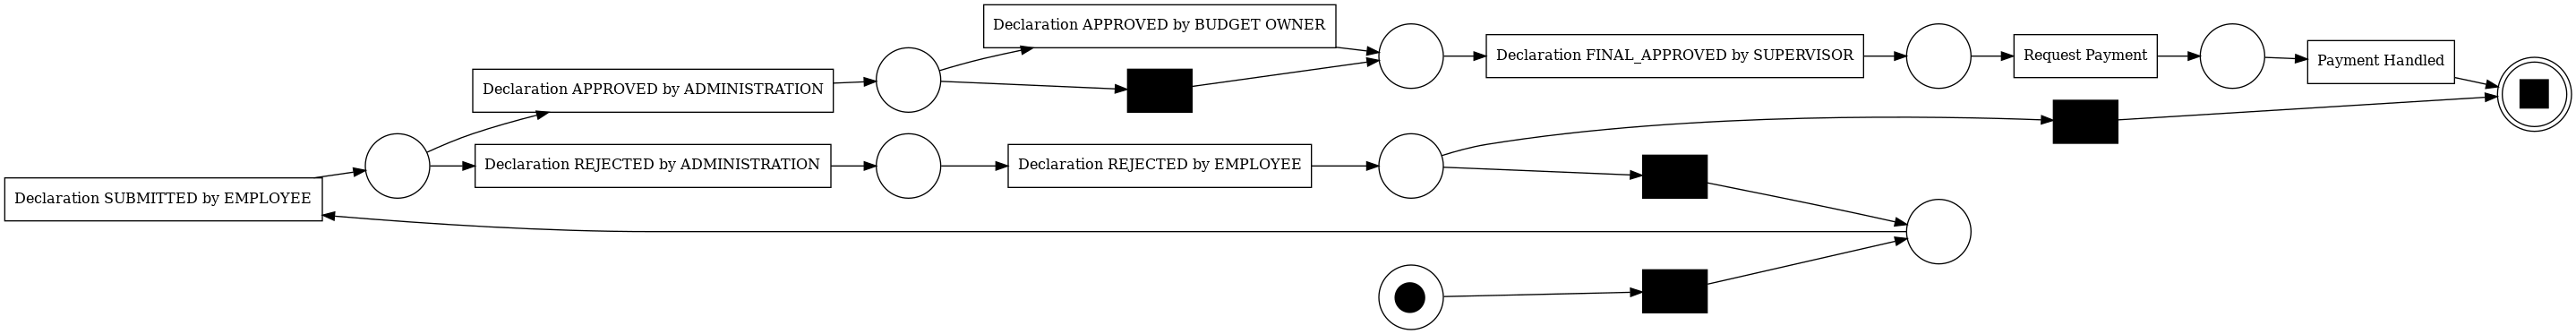

In [ ]:
ps = pss["DomesticDeclaration"]
pars = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: ps[0], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT:ps[1], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES:ps[2]}
net, im, fm = heuristics_miner.apply(d_log_var["nat_dec"], parameters=pars)
dict_nets["DomesticDeclaration"] = (net, im, fm)
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)



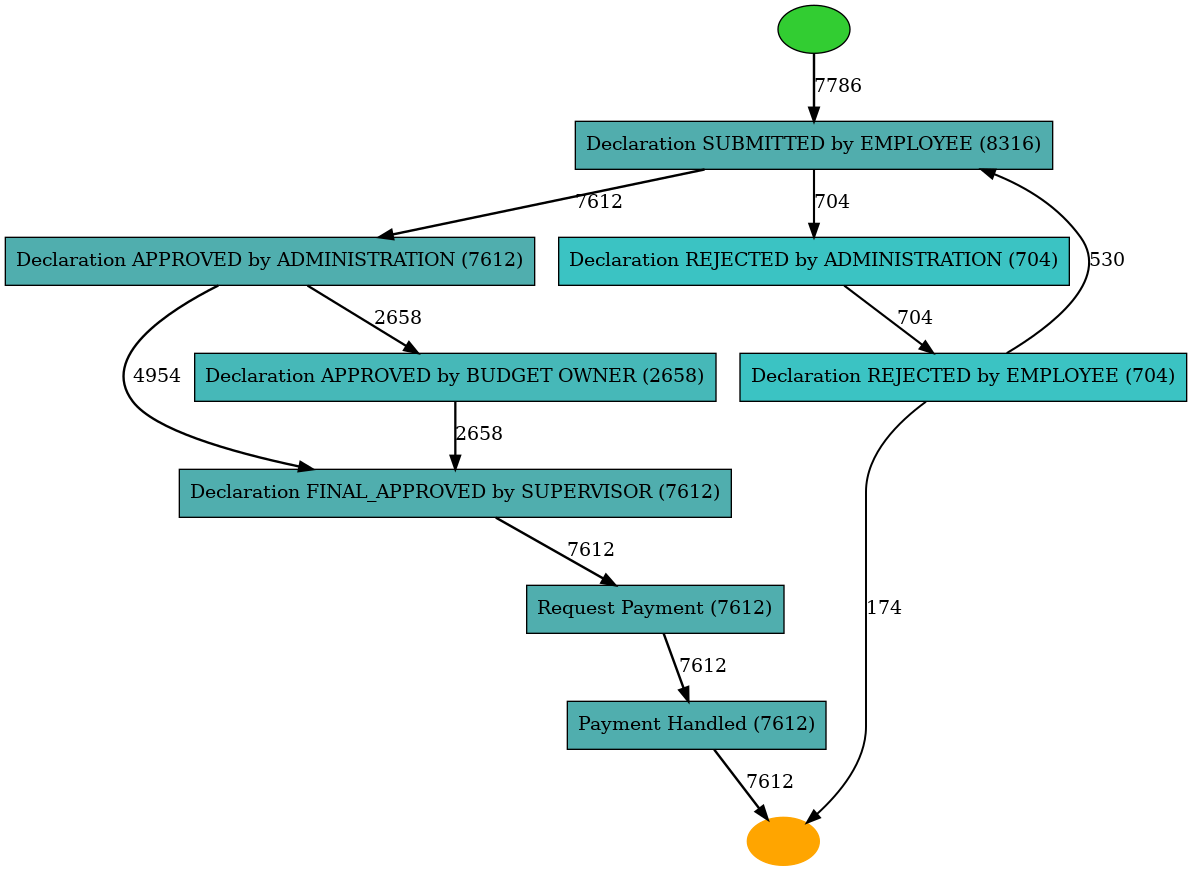

In [ ]:
from pm4py.objects.conversion.process_tree import converter
from pm4py.objects.conversion.wf_net import converter as wf_net_converter
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

#tree = wf_net_converter.apply(net, im, fm)
#print(tree)
heu_net = heuristics_miner.apply_heu(d_log_var["nat_dec"], parameters=pars)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)
#pm4py.objects.conversion.petri_to_bpmn(net, im,fm)
#bpmn_graph = converter.apply(tree, variant=converter.Variants.TO_BPMN)


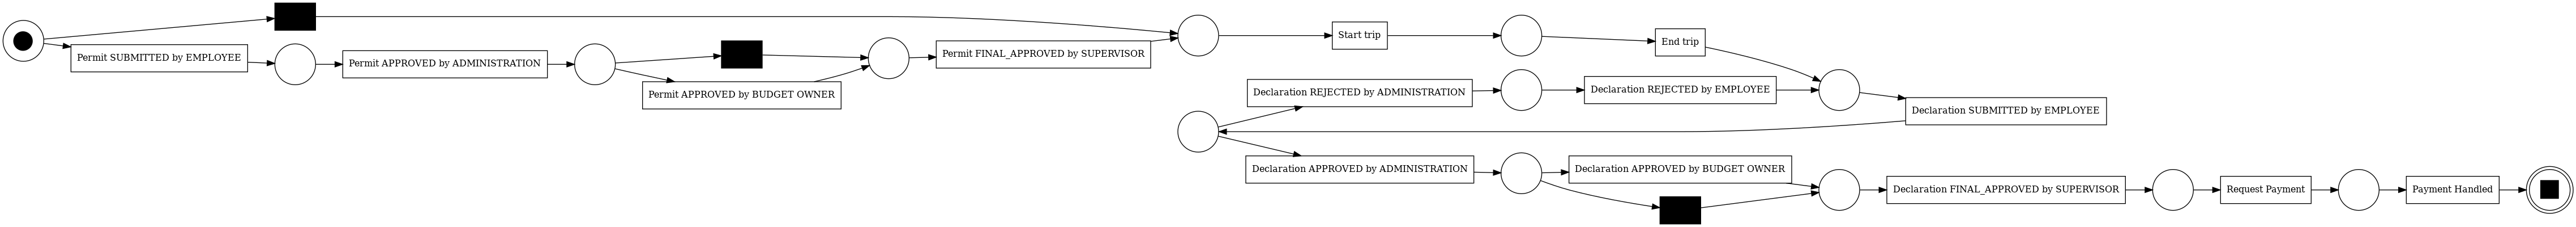

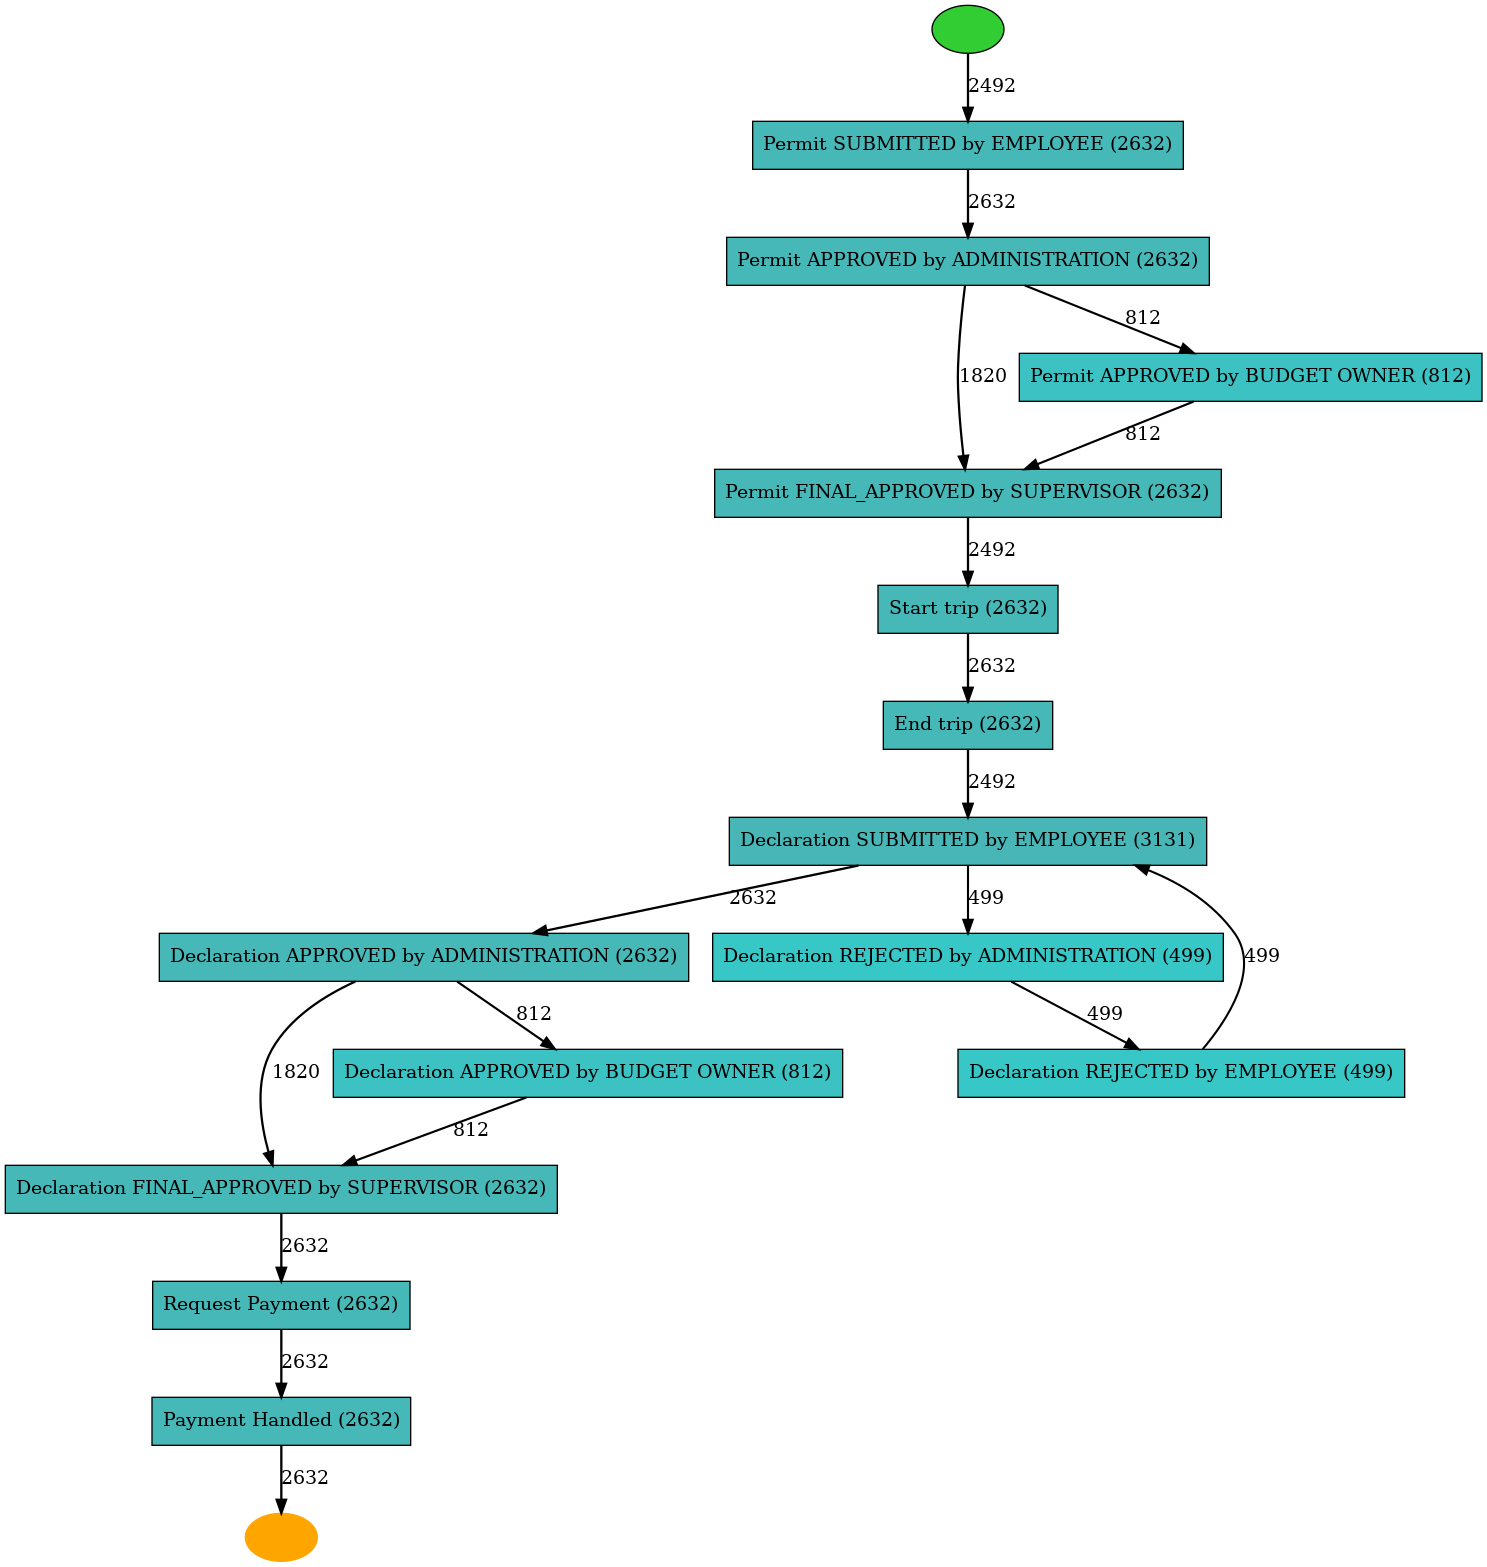

In [ ]:
ps = pss["InternationalDeclaration"]
pars = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: ps[0], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT:ps[1], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES:ps[2]}
net, im, fm = heuristics_miner.apply(d_log_var["int_dec"], parameters=pars)
dict_nets["InternationalDeclaration"] = (net, im, fm)

gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

heu_net = heuristics_miner.apply_heu(d_log_var["int_dec"], parameters=pars)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)



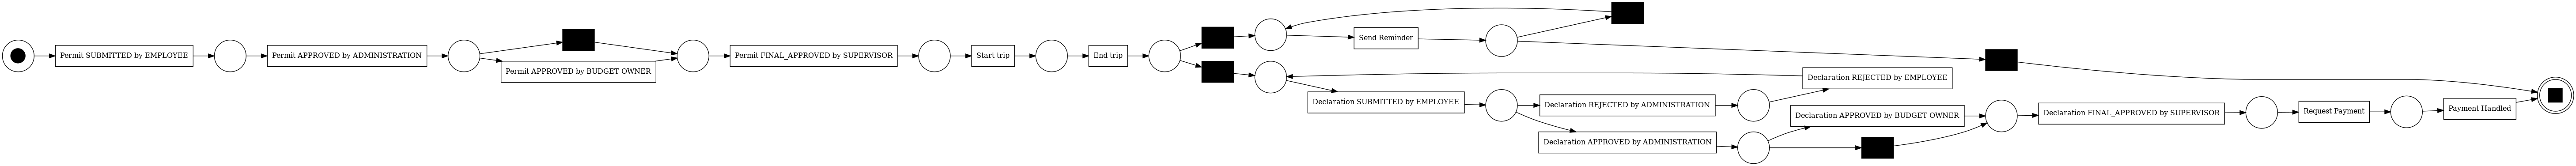

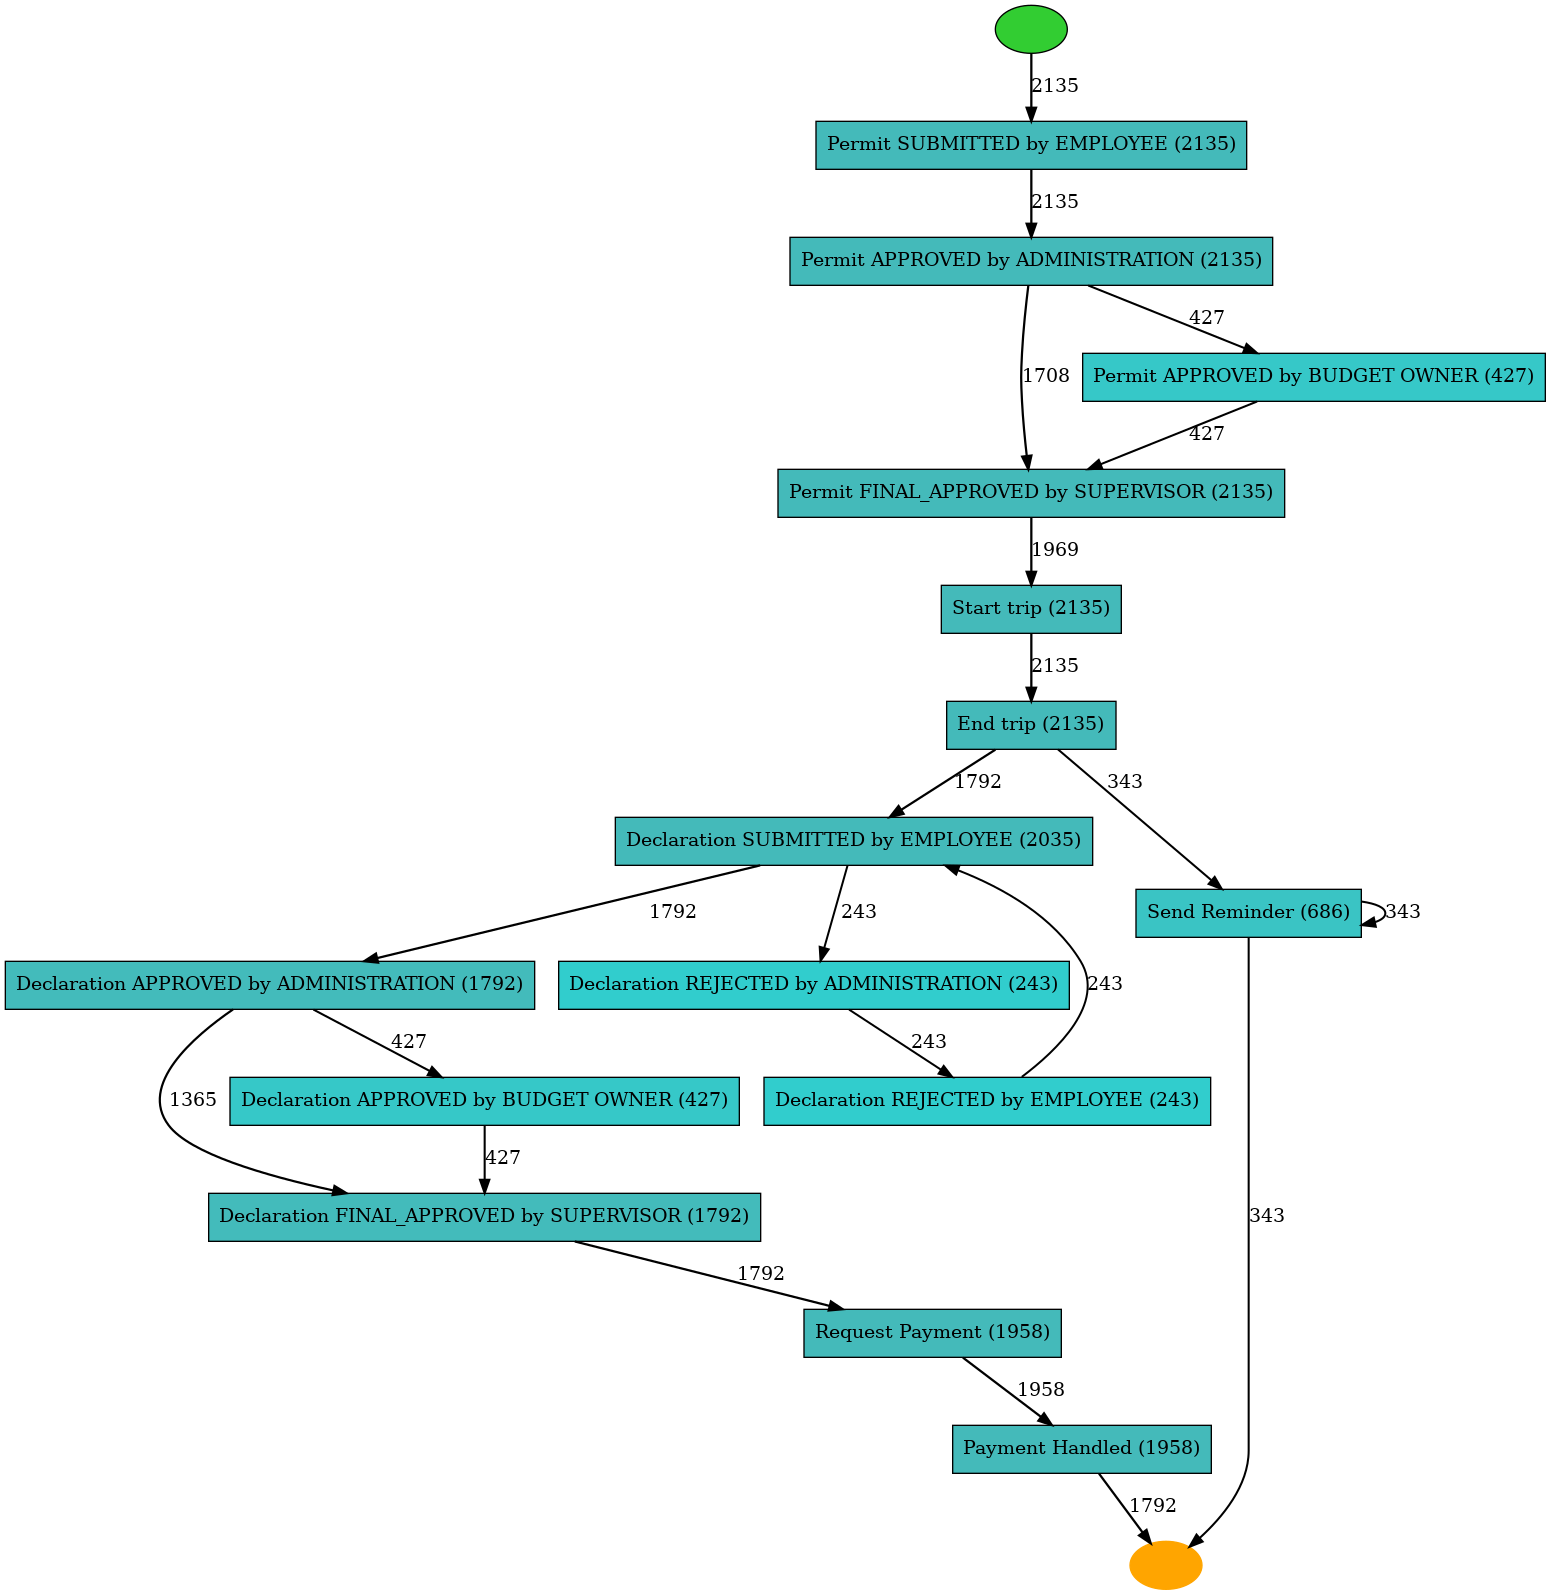

In [ ]:
ps = pss["PermitLog"]

pars = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: ps[0], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT:ps[1], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES:ps[2]}
net, im, fm = heuristics_miner.apply(d_log_var["per_log"], parameters=pars)
dict_nets["PermitLog"] = (net, im, fm)

gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

heu_net = heuristics_miner.apply_heu(d_log_var["per_log"], parameters=pars)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)



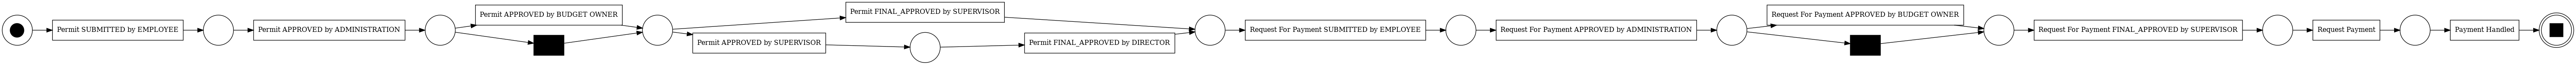

In [ ]:
ps = pss["PrepayedTravelCost"]

net, im, fm = inductive_miner.apply(d_log_var["pre_tra_cost"], variant=inductive_miner.Variants.IMf, parameters={inductive_miner.Variants.IMf:ps[0]})

dict_nets["PrepayedTravelCost"] = (net, im, fm)


gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)



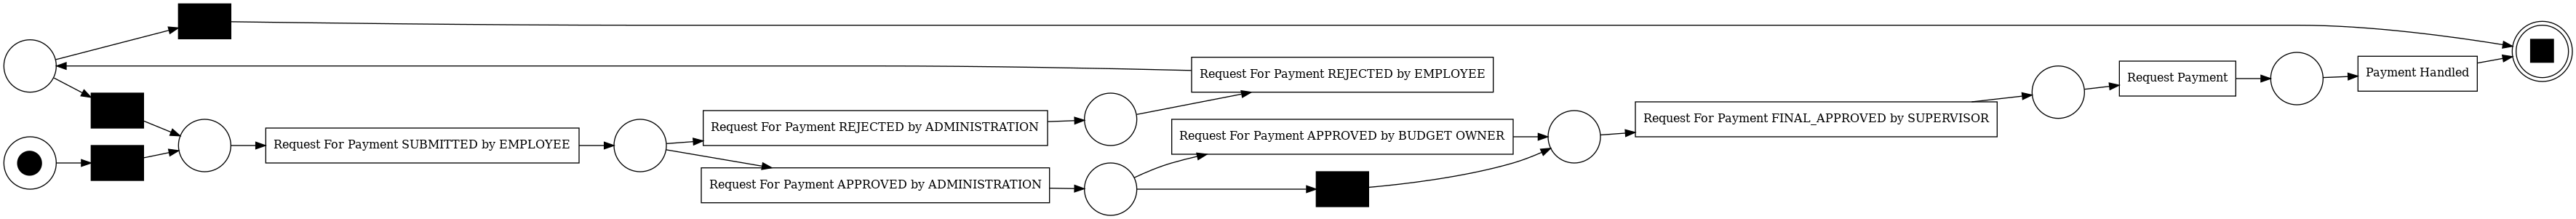

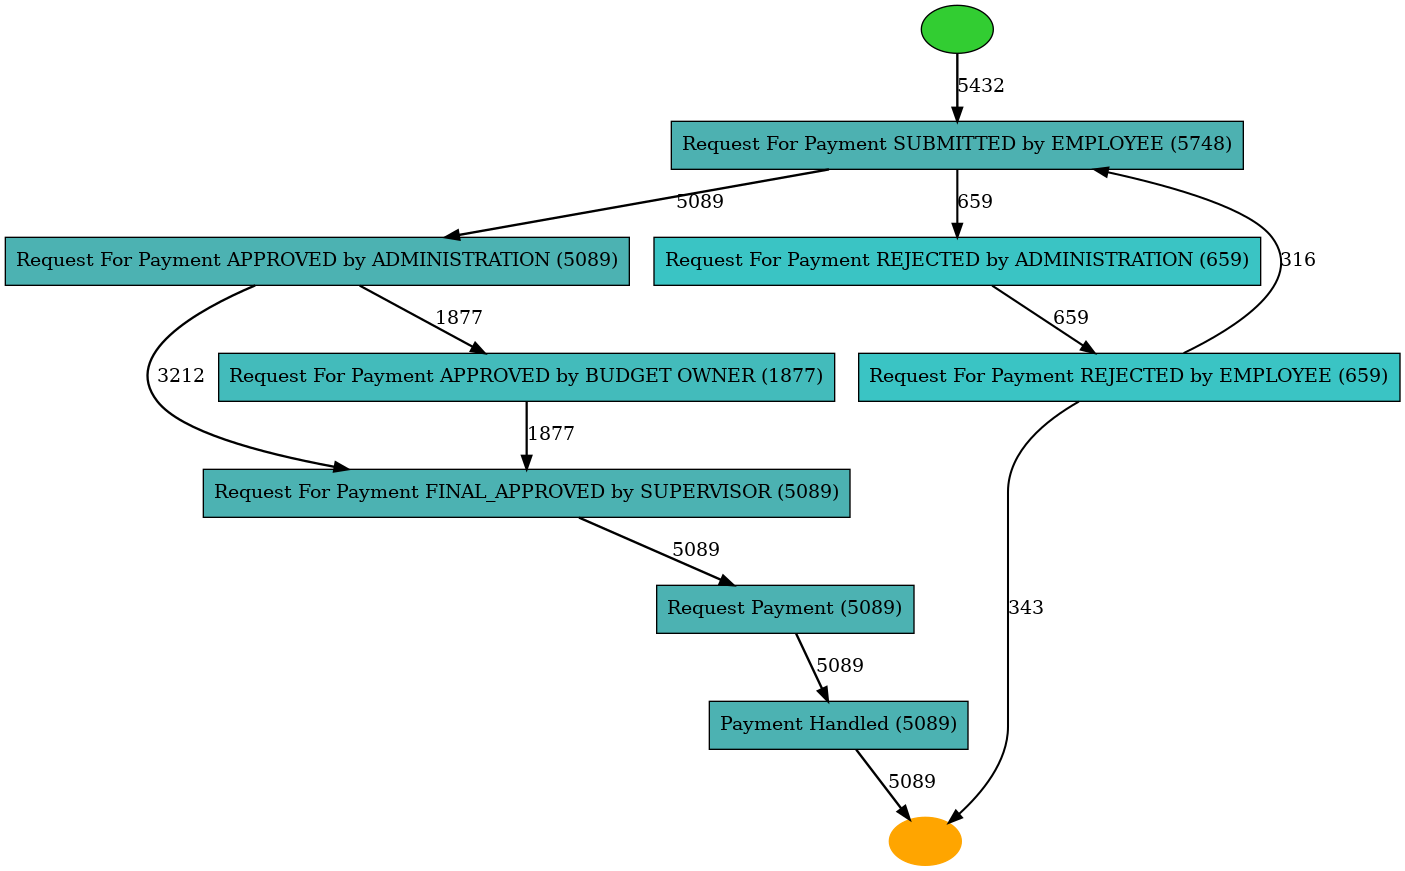

In [ ]:
ps = pss["RequestForPay"]

pars = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: ps[0], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT:ps[1], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES:ps[2]}
net, im, fm = heuristics_miner.apply(d_log_var["req_4_pay"], parameters=pars)
dict_nets["RequestForPay"] = (net, im, fm)

gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)


heu_net = heuristics_miner.apply_heu(d_log_var["req_4_pay"], parameters=pars)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)




# SPLITTING SUCCESSFULL - UNSUCCESSFULL
### NOT IN REPORTED, NOT USEFULL

In [ ]:
from pm4py.algo.filtering.log.end_activities import end_activities_filter

end_activities = end_activities_filter.get_end_activities(d_log["int_dec"])
unpayed = end_activities_filter.apply(d_log["int_dec"], ['Declaration REJECTED by EMPLOYEE', 'Declaration SAVED by EMPLOYEE',  'Send Reminder',  'Request Payment', 'Declaration REJECTED by SUPERVISOR'])
print(f"Unpayed: {len(unpayed)}, Total: {len(d_log['int_dec'])}, % of unpayed wrt total: {round(len(unpayed)/len(d_log['int_dec']),2)}%")


Unpayed: 167, Total: 4952, % of unpayed wrt total: 0.03%


In [ ]:
unpayed = pm4py.filter_variants_top_k(unpayed, 5)
len(unpayed)

236

In [ ]:
res = model_stats(unpayed)

In [ ]:
res[res["SEMPLICITY"]>0].sort_values(["PRECISION"], ascending=False)#.head(1)

,MODEL,PARAMETERS,FITNESS,PRECISION,GENERALIZATION,SEMPLICITY
0,Alpha,[NONE],0.00,1.00,0.91,0.56
220,HEU,"[0.9, 20, 20]",74.15,0.87,0.88,0.72
215,HEU,"[0.9, 1, 20]",74.15,0.87,0.88,0.72
39,HEU,"[0.2, 1, 1]",74.15,0.87,0.88,0.72
40,HEU,"[0.2, 1, 20]",74.15,0.87,0.88,0.72
...,...,...,...,...,...,...
84,HEU,"[0.3, 300, 1]",0.00,0.14,0.91,1.00
85,HEU,"[0.3, 300, 20]",0.00,0.14,0.91,1.00
173,HEU,"[0.7, 20, 300]",0.00,0.14,0.91,1.00
86,HEU,"[0.3, 300, 100]",0.00,0.14,0.91,1.00


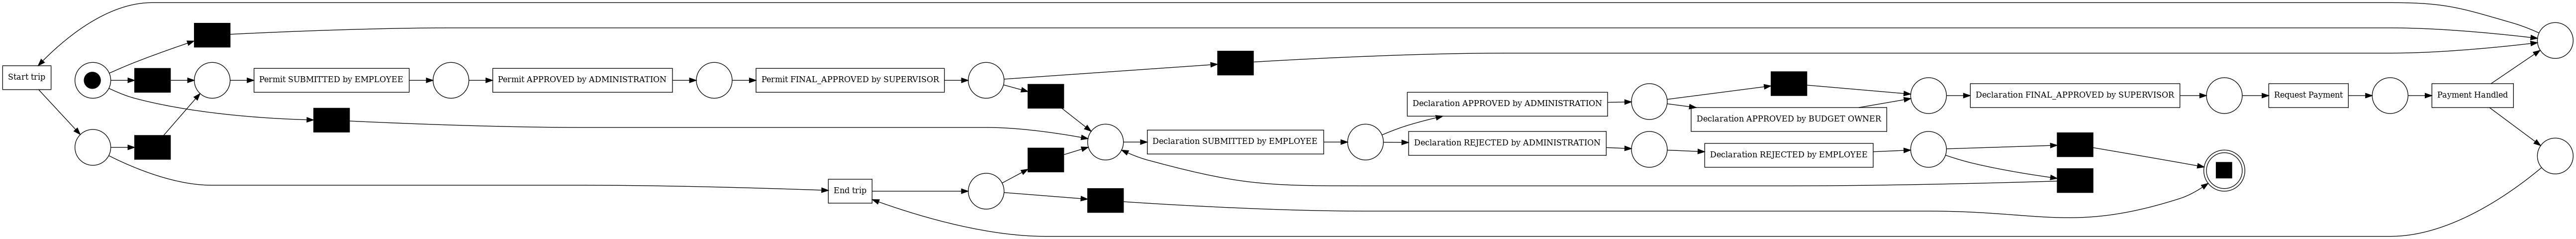

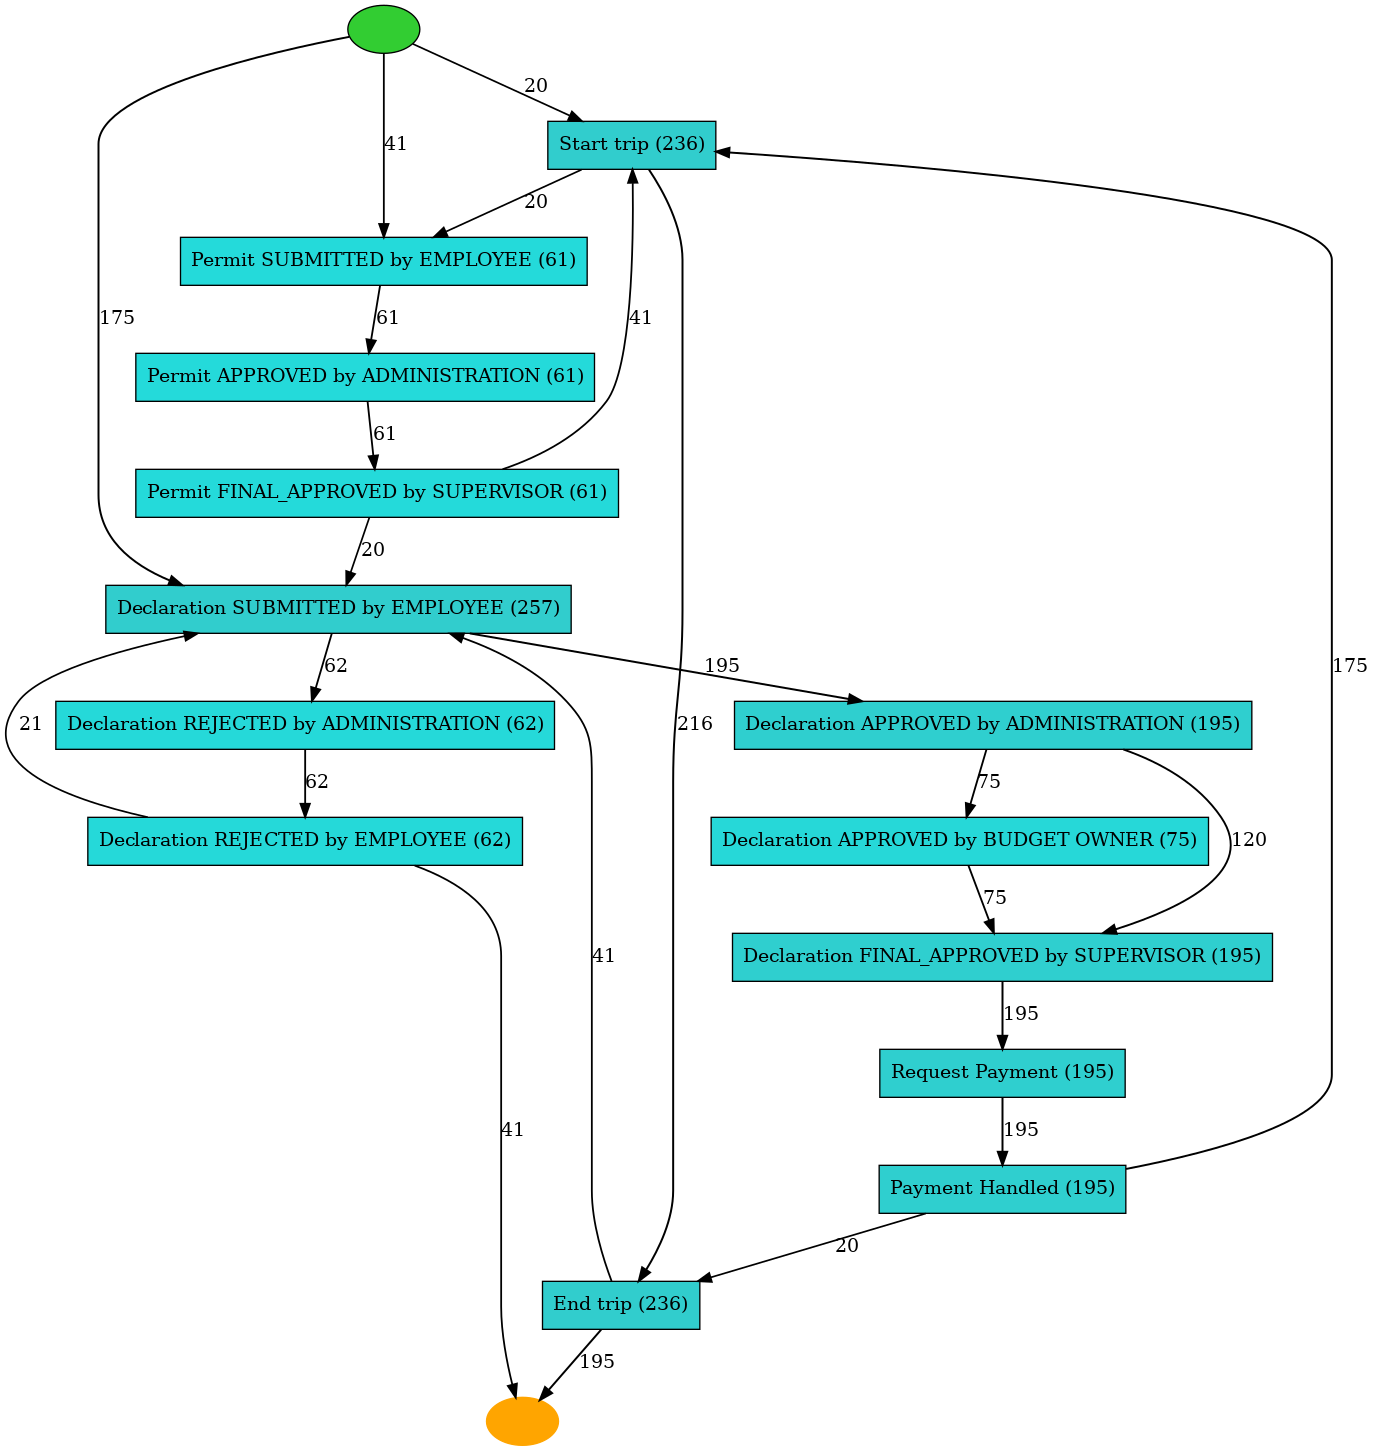

In [ ]:
ps = res[res["SEMPLICITY"]>0.5].sort_values(["FITNESS","PRECISION"], ascending=False).head(1)["PARAMETERS"].to_numpy()[0]
ps = [0.9, 20, 20]		
pars = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: ps[0], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT:ps[1], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES:ps[2]}
net, im, fm = heuristics_miner.apply(unpayed, parameters=pars)

gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)


heu_net = heuristics_miner.apply_heu(unpayed, parameters=pars)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

## Trying to merge Domestic and International starting from top-5 variant filtered logs

### not very useful, as international initially has the permit phase

In [ ]:
d_df_var = {}
for k, v in d_log_var.items():
    d_df_var[k] = log_to_df(v)
d_df_var.keys()

dict_keys(['nat_dec', 'int_dec', 'per_log', 'pre_tra_cost', 'req_4_pay'])

In [ ]:
# Find shared columns between 5 logs
shared = set()
dict_cols = {}
for k in ['nat_dec', 'int_dec']:
    for c in d_df_var[k].columns:
        if c in dict_cols.keys():
            dict_cols[c] += 1
        else:
             dict_cols[c] = 1
        
shared = [k for k, v in dict_cols.items() if v == 2]
shared

['id',
 'org:resource',
 'concept:name',
 'time:timestamp',
 'org:role',
 'case:id',
 'case:concept:name',
 'case:BudgetNumber',
 'case:DeclarationNumber',
 'case:Amount']

In [ ]:
d_df_var.keys()

dict_keys(['nat_dec', 'int_dec', 'per_log', 'pre_tra_cost', 'req_4_pay'])

In [ ]:
l_res = []
log_to_use = ['nat_dec', 'int_dec']
for k in log_to_use:
    l_res.append(d_df_var[k][shared])

df_all = pd.concat(l_res)

In [ ]:
log_all = df_to_log(df_all)

In [ ]:
res_dec = model_stats(log_all)

In [ ]:
m_n = res_dec
m_n[(m_n["SEMPLICITY"]>=.74) & (m_n["PRECISION"]>.5) & (m_n["FITNESS"]>50)].sort_values(["SEMPLICITY","FITNESS", "PRECISION", "GENERALIZATION"], ascending=False)


,MODEL,PARAMETERS,FITNESS,PRECISION,GENERALIZATION,SEMPLICITY
17,HEU,"[0.1, 1, 200]",98.66,0.97,0.98,0.78
18,HEU,"[0.1, 1, 300]",98.66,0.97,0.98,0.78
22,HEU,"[0.1, 20, 200]",98.66,0.97,0.98,0.78
23,HEU,"[0.1, 20, 300]",98.66,0.97,0.98,0.78
27,HEU,"[0.1, 100, 200]",98.66,0.97,0.98,0.78
...,...,...,...,...,...,...
8,IMf,[0.6],98.33,0.67,0.98,0.75
9,IMf,[0.7],98.33,0.67,0.98,0.75
10,IMf,[0.8],98.33,0.67,0.98,0.75
11,IMf,[0.9],98.33,0.67,0.98,0.75


In [ ]:
ps = [0.1, 1, 200]

pars = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: ps[0], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT:ps[1], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES:ps[2]}
net, im, fm = heuristics_miner.apply(log_all, parameters=pars)

In [ ]:
metrics(net, im, fm, log_all)

replaying log with TBR, completed variants :: 100%|██████████| 10/10 [00:00<00:00, 210.10it/s]


(98.66, 0.97, 0.98, 0.78)

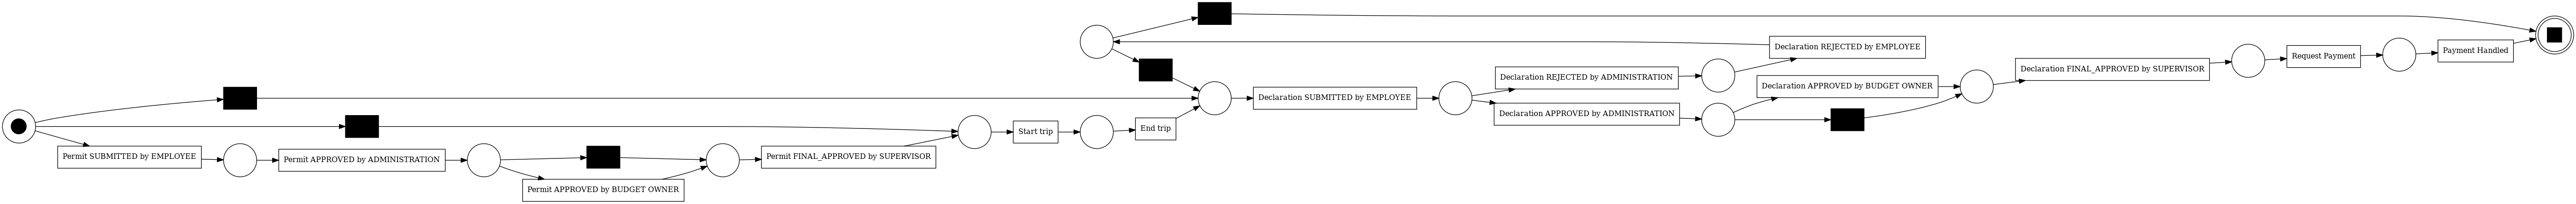

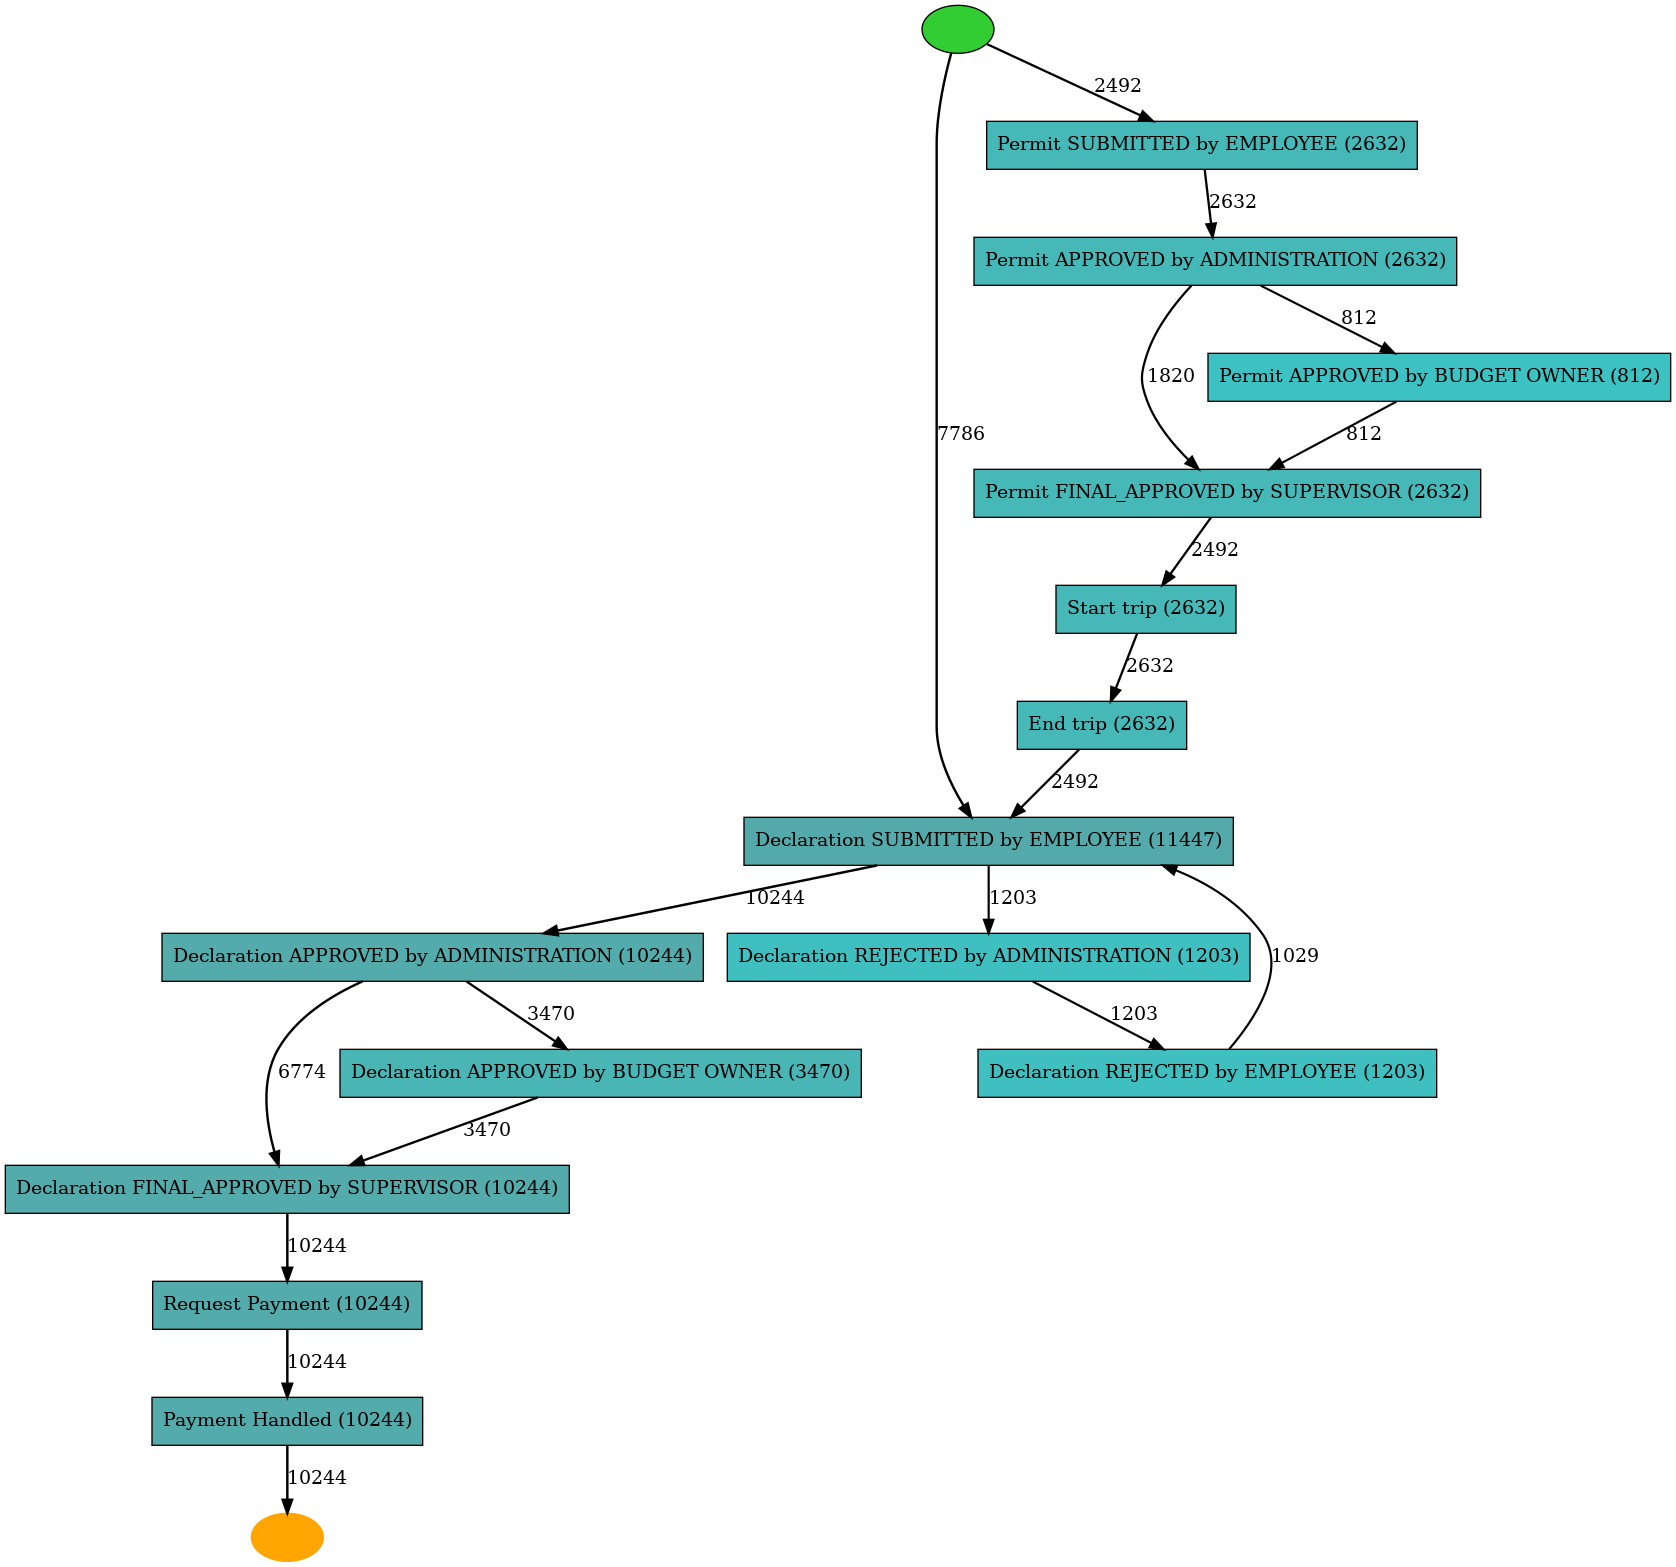

In [ ]:
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

heu_net = heuristics_miner.apply_heu(log_all, parameters=pars)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

# CONFORMANCE CHECKING

In [ ]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

def align(log, net, im, fm):
	aligned_traces = alignments.apply_log(log, net, im, fm)

	print("ALIGNMENTS")
	print("Number of traces", len(aligned_traces))
	regular_traces = []
	anomalous_traces = []
	case_ids = []
	i = 0
	while i < len(aligned_traces):
		if aligned_traces[i]["fitness"] != 1:
			anomalous_traces.append(aligned_traces[i]['alignment'])
			case_ids.append(log[i].attributes["concept:name"])
		else:
			regular_traces.append(aligned_traces[i]['alignment'])
		i += 1
	print("Number of anomalous traces ", len(anomalous_traces))
	print("Number of normal traces ", len(regular_traces))
	print("Percentage of anomalous traces", (len(anomalous_traces)/len(aligned_traces))*100 , '%')
	print("Odds of anomalous traces", round(len(anomalous_traces)/len(regular_traces),2))

	return anomalous_traces, case_ids


In [ ]:
_ = align(d_log_var["nat_dec"], *dict_nets["DomesticDeclaration"])

aligning log, completed variants :: 100%|██████████| 5/5 [00:00<00:00, 492.61it/s]

ALIGNMENTS
Number of traces 7786
Number of anomalous traces  0
Number of normal traces  7786
Percentage of anomalous traces 0.0 %
Odds of anomalous traces 0.0


In [ ]:
an_int_dec = align(d_log_var["int_dec"], *dict_nets["InternationalDeclaration"])

aligning log, completed variants :: 100%|██████████| 5/5 [00:00<00:00, 182.78it/s]

ALIGNMENTS
Number of traces 2632
Number of anomalous traces  140
Number of normal traces  2492
Percentage of anomalous traces 5.319148936170213 %
Odds of anomalous traces 0.06


In [ ]:
an_int_dec[0]
#cases that start with a start trip and apply later
#so all the cases not covered are those that start from a start trip and then follow the classic inter of submissions and approvals, a case that perhaps shouldn't be possible?
from pm4py.algo.filtering.log.start_activities import start_activities_filter
log_start = start_activities_filter.get_start_activities(d_log_var["int_dec"])
filtered_log = start_activities_filter.apply(d_log_var["int_dec"], ["Start trip"]) 

len(filtered_log)

140

In [ ]:
an_per_log = align(d_log_var["per_log"], *dict_nets["PermitLog"])

aligning log, completed variants :: 100%|██████████| 5/5 [00:00<00:00, 186.01it/s]

ALIGNMENTS
Number of traces 2135
Number of anomalous traces  166
Number of normal traces  1969
Percentage of anomalous traces 7.775175644028103 %
Odds of anomalous traces 0.08


In [ ]:
an_pre_tra = align(d_log_var["pre_tra_cost"], *dict_nets["PrepayedTravelCost"])

aligning log, completed variants :: 100%|██████████| 5/5 [00:00<00:00, 321.64it/s]

ALIGNMENTS
Number of traces 1199
Number of anomalous traces  93
Number of normal traces  1106
Percentage of anomalous traces 7.756463719766472 %
Odds of anomalous traces 0.08


In [ ]:
start_activities_filter.get_start_activities(d_log_var["pre_tra_cost"])

{'Permit SUBMITTED by EMPLOYEE': 1106,
 'Request For Payment SUBMITTED by EMPLOYEE': 93}

In [ ]:
log_start = start_activities_filter.get_start_activities(d_log_var["pre_tra_cost"])
filtered_log = start_activities_filter.apply(d_log_var["pre_tra_cost"], ["Request For Payment SUBMITTED by EMPLOYEE"]) 
len(filtered_log)

# practically employees ask for money before submitting permits

93

In [ ]:
_ = align(d_log_var["req_4_pay"], *dict_nets["RequestForPay"])

aligning log, completed variants :: 100%|██████████| 5/5 [00:00<00:00, 286.12it/s]

ALIGNMENTS
Number of traces 5432
Number of anomalous traces  0
Number of normal traces  5432
Percentage of anomalous traces 0.0 %
Odds of anomalous traces 0.0


# MERGE REQUEST FOR PAYMENTS AND DOMESTIC DECLARATIONS

In [ ]:
req4 = log_to_df(d_log_var["req_4_pay"])
nat = log_to_df(d_log_var["nat_dec"])
prefix = "Request For Payment "
req4["concept:name"] = req4["concept:name"].map(lambda x: x[len(prefix):] if x[:len(prefix)]==prefix else x)
prefix = "Declaration "
nat["concept:name"] = nat["concept:name"].map(lambda x: x[len(prefix):] if x[:len(prefix)]==prefix else x)
all = df_to_log(pd.concat([nat, req4]))


In [ ]:
len(all)

13218

In [ ]:
r = model_stats(all)

In [ ]:
r[r["SEMPLICITY"]>0.8].sort_values(["FITNESS","PRECISION"], ascending=False)#.head(1)

,MODEL,PARAMETERS,FITNESS,PRECISION,GENERALIZATION,SEMPLICITY
14,HEU,"[0.1, 1, 1]",100.0,0.99,0.98,0.85
15,HEU,"[0.1, 1, 20]",100.0,0.99,0.98,0.85
16,HEU,"[0.1, 1, 100]",100.0,0.99,0.98,0.85
17,HEU,"[0.1, 1, 200]",100.0,0.99,0.98,0.85
18,HEU,"[0.1, 1, 300]",100.0,0.99,0.98,0.85
...,...,...,...,...,...,...
260,HEU,"[1.0, 300, 20]",93.6,0.19,0.99,1.00
261,HEU,"[1.0, 300, 100]",93.6,0.19,0.99,1.00
262,HEU,"[1.0, 300, 200]",93.6,0.19,0.99,1.00
263,HEU,"[1.0, 300, 300]",93.6,0.19,0.99,1.00


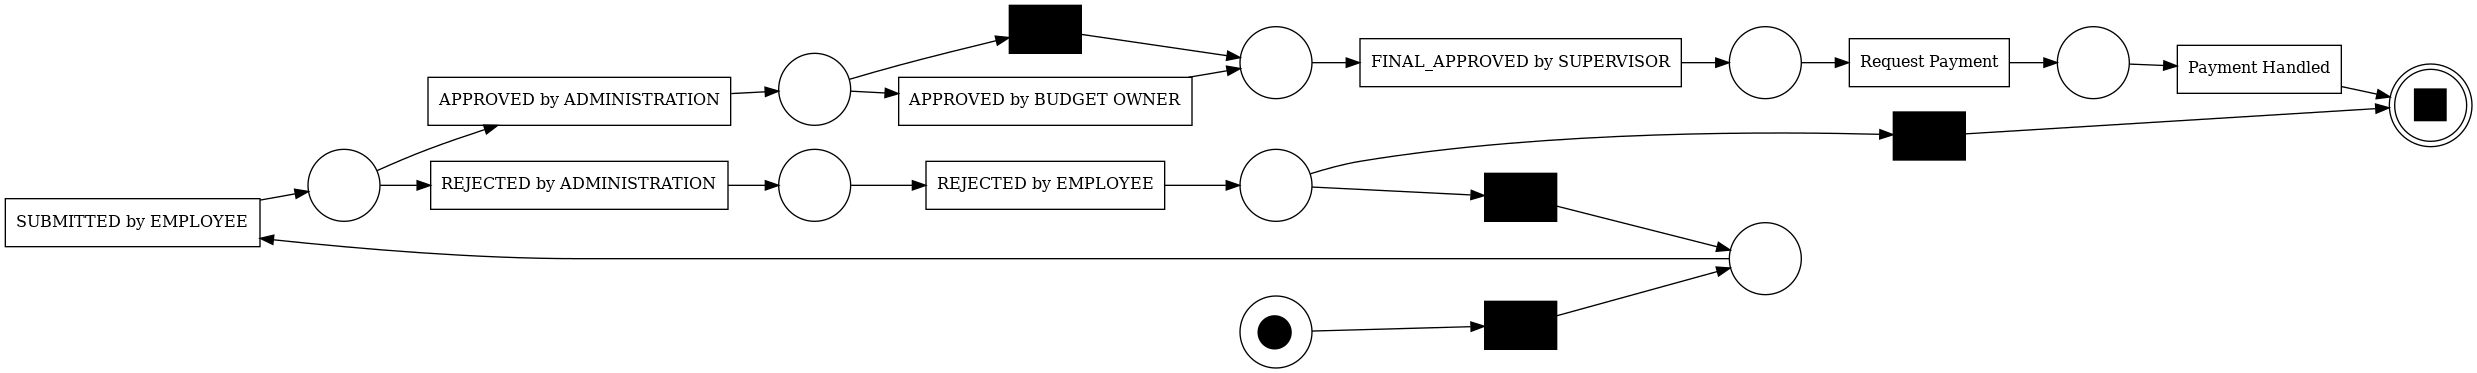

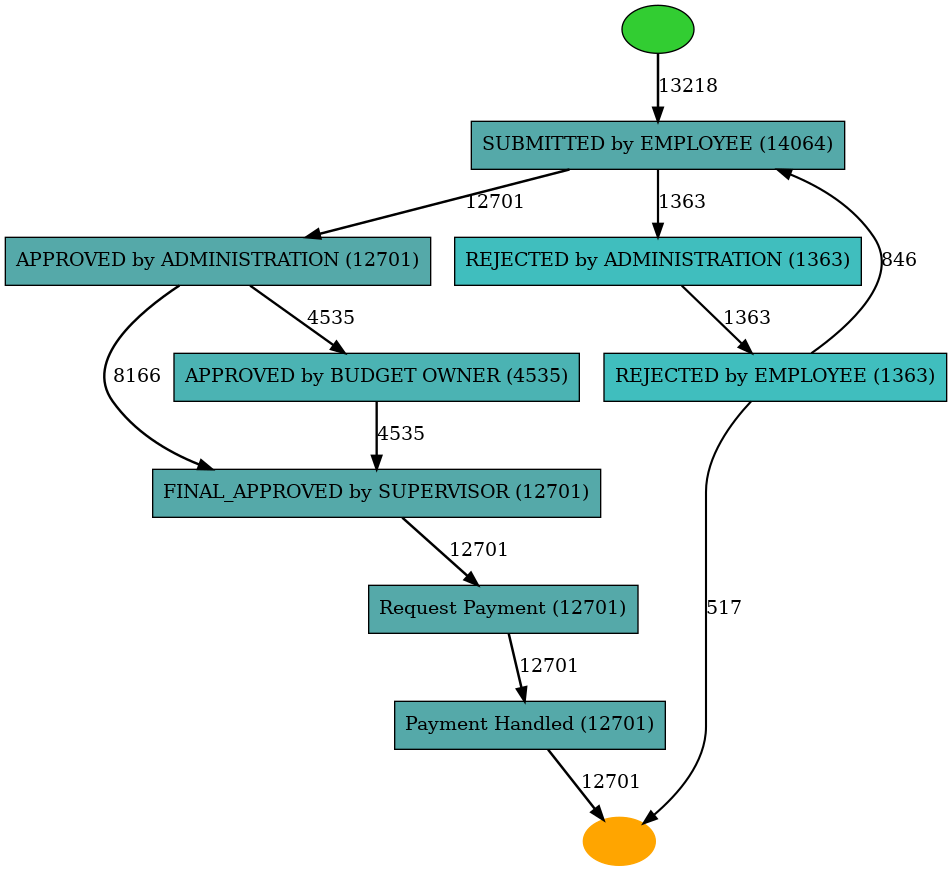

In [ ]:
ps = [0.1, 1, 20]

pars = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: ps[0], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT:ps[1], 
        heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES:ps[2]}
net, im, fm = heuristics_miner.apply(all, parameters=pars)

gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

heu_net = heuristics_miner.apply_heu(all, parameters=pars)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [ ]:
align(all, net, im, fm)

aligning log, completed variants :: 100%|██████████| 5/5 [00:00<00:00, 323.01it/s]

ALIGNMENTS
Number of traces 13218
Number of anomalous traces  0
Number of normal traces  13218
Percentage of anomalous traces 0.0 %
Odds of anomalous traces 0.0


([], [])

# PREDICT OVERSPENT

In [ ]:
int_ = d_df["int_dec"][(d_df["int_dec"]["case:concept:name"].notna()) & (d_df["int_dec"]["case:concept:name"] != "UNKNOWN")].sort_values("time:timestamp").groupby("case:concept:name").nth((0,-1)).groupby("case:concept:name")

In [ ]:
diff_times = int_["time:timestamp"].diff().dropna().map(lambda x: (x.days))
diff_times


case:concept:name
declaration 1002     -40
declaration 10024    -63
declaration 10026    -63
declaration 10046    -87
declaration 10069     -9
                    ... 
declaration 9934     -53
declaration 9945     -50
declaration 9955     -94
declaration 9968     -31
declaration 9995     226
Name: time:timestamp, Length: 4952, dtype: int64

In [ ]:
int_single_row = d_df["int_dec"][(d_df["int_dec"]["case:concept:name"].notna()) & (d_df["int_dec"]["case:concept:name"] != "UNKNOWN")].sort_values("time:timestamp").groupby("case:concept:name").nth((0,-1)).reset_index()[["case:concept:name","case:Amount", "case:Permit RequestedBudget","case:AdjustedAmount", "case:Permit ID"]].drop_duplicates()

In [ ]:
int_single_row_time = int_single_row.merge(diff_times, on="case:concept:name")
int_single_row_time.sort_values("case:concept:name").head()

,case:concept:name,case:Amount,case:Permit RequestedBudget,case:AdjustedAmount,case:Permit ID,time:timestamp
0,declaration 1002,361.392240,1273.252058,361.392240,travel permit 992,-40
1,declaration 10024,202.138426,2134.047941,202.138426,travel permit 10022,-63
2,declaration 10026,481.038280,2134.047941,481.038280,travel permit 10022,-63
3,declaration 10046,525.361223,2531.512736,525.361223,travel permit 10040,-87
4,declaration 10069,71.195831,64.878503,71.195831,travel permit 10066,-9


In [ ]:
int_single_row_time[int_single_row_time["case:Permit ID"]=="travel permit 10022"]

,case:concept:name,case:Amount,case:Permit RequestedBudget,case:AdjustedAmount,case:Permit ID,time:timestamp
1,declaration 10024,202.138426,2134.047941,202.138426,travel permit 10022,-63
2,declaration 10026,481.038280,2134.047941,481.038280,travel permit 10022,-63


In [ ]:
int_single_row_time["case:Permit ID"].value_counts()

travel permit 53343    14
travel permit 32577    10
travel permit 45618    10
travel permit 69266     8
travel permit 64232     7
                       ..
travel permit 30675     1
travel permit 30710     1
travel permit 3071      1
travel permit 30726     1
travel permit 9984      1
Name: case:Permit ID, Length: 4616, dtype: int64

In [ ]:
per_ = d_df["per_log"][(d_df["per_log"]["case:concept:name"].notna()) & (d_df["per_log"]["case:concept:name"] != "UNKNOWN")].sort_values("time:timestamp").groupby("case:concept:name").nth((0,-1)).groupby("case:concept:name")#.dropna(axis=1)#["case:Overspent"].value_counts()
per_.head()

,id,org:resource,concept:name,time:timestamp,org:role,case:OrganizationalEntity,case:ProjectNumber,case:TaskNumber,case:dec_id_0,case:ActivityNumber,...,case:Cost Type_14,case:Cost Type_10,case:Cost Type_11,case:Cost Type_12,case:Task_5,case:Task_4,case:Task_9,case:Task_8,case:Task_7,case:Task_6
case:concept:name,,,,,,,,,,,,,,,,,,,,,
travel permit 10022,fd_declaration 10026_18,SYSTEM,Payment Handled,2018-04-23 17:31:11+02:00,UNDEFINED,organizational unit 65466,UNKNOWN,UNKNOWN,declaration 10024,UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
travel permit 10022,st_step 10031_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2018-02-20 13:51:27+01:00,EMPLOYEE,organizational unit 65466,UNKNOWN,UNKNOWN,declaration 10024,UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
travel permit 10040,fd_declaration 10046_18,SYSTEM,Payment Handled,2018-05-17 17:31:34+02:00,UNDEFINED,organizational unit 65466,project 10042,task 427,NaN,UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
travel permit 10040,st_step 10050_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2018-02-20 13:53:11+01:00,EMPLOYEE,organizational unit 65466,project 10042,task 427,NaN,UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
travel permit 10060,st_step 10065_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2018-02-20 17:29:10+01:00,EMPLOYEE,organizational unit 65458,UNKNOWN,UNKNOWN,NaN,UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
travel permit 9953,st_step 9959_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2018-02-20 09:45:04+01:00,EMPLOYEE,organizational unit 65469,UNKNOWN,UNKNOWN,declaration 9955,activity 2401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
travel permit 9965,fd_declaration 9968_18,SYSTEM,Payment Handled,2018-03-08 17:31:00+01:00,UNDEFINED,organizational unit 65454,project 9967,task 427,declaration 9968,UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
travel permit 9965,rv_travel permit 9965_6,STAFF MEMBER,Start trip,2018-02-06 00:00:00+01:00,EMPLOYEE,organizational unit 65454,project 9967,task 427,declaration 9968,UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
diff_times = per_["time:timestamp"].diff().dropna().map(lambda x: (x.days))
diff_times


case:concept:name
travel permit 10022    -63
travel permit 10040    -87
travel permit 10060    253
travel permit 10066     -9
travel permit 10077   -148
                      ... 
travel permit 9931      52
travel permit 9942      49
travel permit 9953     -94
travel permit 9965     -31
travel permit 9984     226
Name: time:timestamp, Length: 5598, dtype: int64

In [ ]:
diff_trav = d_df["per_log"][d_df["per_log"]["concept:name"].isin(["Start trip", "End trip"])].sort_values("time:timestamp").groupby("case:concept:name").nth((0,-1)).groupby("case:concept:name")["time:timestamp"].diff().dropna().map(lambda x: (x.days))
diff_trav

case:concept:name
travel permit 10022    -5
travel permit 10040    -7
travel permit 10060   -30
travel permit 10066     0
travel permit 10077    14
                       ..
travel permit 9931     11
travel permit 9942     -3
travel permit 9953      2
travel permit 9965     -2
travel permit 9984     96
Name: time:timestamp, Length: 5598, dtype: int64

In [ ]:
per_single_row = d_df["per_log"][(d_df["per_log"]["case:concept:name"].notna()) & (d_df["per_log"]["case:concept:name"] != "UNKNOWN")].sort_values("time:timestamp").groupby("case:concept:name").nth((-1)).reset_index()[["case:concept:name","case:Overspent", "case:RequestedBudget","case:OverspentAmount", "case:TotalDeclared"]]#.drop_duplicates()

In [ ]:
per_single_row_time = per_single_row.merge(diff_times, on="case:concept:name").drop_duplicates("case:concept:name")
per_single_row_time = per_single_row_time.merge(diff_trav, on="case:concept:name").drop_duplicates("case:concept:name")
per_single_row_time.rename(columns = {'case:concept:name':'case:Permit ID'}, inplace = True)
per_single_row_time

,case:Permit ID,case:Overspent,case:RequestedBudget,case:OverspentAmount,case:TotalDeclared,time:timestamp_x,time:timestamp_y
0,travel permit 10022,False,2134.047941,-50.662542,683.176706,-63,-5
1,travel permit 10040,False,2531.512736,-646.643989,2655.207272,-87,-7
2,travel permit 10060,False,0.000000,0.000000,0.000000,253,-30
3,travel permit 10066,False,64.878503,-18.925474,71.195831,-9,0
4,travel permit 10077,False,1108.578485,-1373.918112,658.505131,-148,14
...,...,...,...,...,...,...,...
5593,travel permit 9931,False,862.215942,-209.958776,588.130139,52,11
5594,travel permit 9942,True,424.535596,22.209388,966.108393,49,-3
5595,travel permit 9953,True,666.621765,348.657286,1539.687646,-94,2
5596,travel permit 9965,False,248.404859,-6.069585,337.873587,-31,-2


In [ ]:
merged = per_single_row_time.merge(int_single_row_time, on="case:Permit ID")
(merged).corr()

,case:Overspent,case:RequestedBudget,case:OverspentAmount,case:TotalDeclared,time:timestamp_x,time:timestamp_y,case:Amount,case:Permit RequestedBudget,case:AdjustedAmount,time:timestamp
case:Overspent,1.000000,-0.031160,0.494600,0.238889,-0.025087,-0.047438,0.122257,-0.031160,0.122240,0.016875
case:RequestedBudget,-0.031160,1.000000,-0.283150,0.735002,-0.023285,-0.045129,0.509022,1.000000,0.509057,-0.014122
case:OverspentAmount,0.494600,-0.283150,1.000000,0.189285,-0.093852,-0.060374,0.041477,-0.283150,0.041383,0.029687
case:TotalDeclared,0.238889,0.735002,0.189285,1.000000,-0.073989,-0.113228,0.708102,0.735002,0.708091,0.019212
time:timestamp_x,-0.025087,-0.023285,-0.093852,-0.073989,1.000000,0.160385,0.015067,-0.023285,0.015052,-0.038465
time:timestamp_y,-0.047438,-0.045129,-0.060374,-0.113228,0.160385,1.000000,0.023214,-0.045129,0.023212,0.052105
case:Amount,0.122257,0.509022,0.041477,0.708102,0.015067,0.023214,1.000000,0.509022,0.999998,0.003986
case:Permit RequestedBudget,-0.031160,1.000000,-0.283150,0.735002,-0.023285,-0.045129,0.509022,1.000000,0.509057,-0.014122
case:AdjustedAmount,0.122240,0.509057,0.041383,0.708091,0.015052,0.023212,0.999998,0.509057,1.000000,0.003970
time:timestamp,0.016875,-0.014122,0.029687,0.019212,-0.038465,0.052105,0.003986,-0.014122,0.003970,1.000000


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


In [ ]:
y=merged.pop("case:Overspent")

In [ ]:
merged.columns

Index(['case:Permit ID', 'case:RequestedBudget', 'case:OverspentAmount',
       'case:TotalDeclared', 'time:timestamp_x', 'time:timestamp_y',
       'case:concept:name', 'case:Amount', 'case:Permit RequestedBudget',
       'case:AdjustedAmount', 'time:timestamp'],
      dtype='object')

In [ ]:
cols_predictor = ['case:RequestedBudget',
       'time:timestamp_x', 'time:timestamp_y',
     'case:Permit RequestedBudget',
       'time:timestamp', 'case:TotalDeclared']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(merged[cols_predictor], y, stratify=y)

In [ ]:
x_train

,case:RequestedBudget,time:timestamp_x,time:timestamp_y,case:Permit RequestedBudget,time:timestamp,case:TotalDeclared
2327,3276.267892,120,-6,3276.267892,-121,2111.861825
3641,3011.016262,-93,9,3011.016262,92,2609.419506
3889,806.916943,-103,3,806.916943,-103,916.540985
3579,864.345588,-51,3,864.345588,50,118.548766
2191,1499.723332,-55,-7,1499.723332,54,1132.797330
...,...,...,...,...,...,...
1313,577.376974,87,3,577.376974,-88,32.368028
4563,404.625175,48,5,404.625175,48,498.392191
4393,1413.778935,-61,3,1413.778935,-61,949.580336
1196,473.855908,-79,1,473.855908,-79,297.487169


In [ ]:
y.value_counts()

False    3043
True     1643
Name: case:Overspent, dtype: int64

In [ ]:
knn = KNeighborsClassifier()
dectree = DecisionTreeClassifier(random_state=42,class_weight="balanced")
bayees = GaussianNB()
rf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced")

In [ ]:
ms = [knn,dectree,bayees,rf]
for m in ms:
    m.fit(x_train,y_train)
    print(accuracy_score(y_train, m.predict(x_train)))
    print(accuracy_score(y_test, m.predict(x_test)))
    print(confusion_matrix(y_test, m.predict(x_test)))

    print("-"*10)

0.8019351166761526
0.71160409556314
[[623 138]
 [200 211]]
----------
1.0
0.6834470989761092
[[580 181]
 [190 221]]
----------
0.6713147410358565
0.6808873720136519
[[721  40]
 [334  77]]
----------
1.0
0.7525597269624573
[[671  90]
 [200 211]]
----------


In [ ]:
for est in [10,20,50,75,100,150,200,300]:
    rf = RandomForestClassifier(n_estimators=est, random_state=42, class_weight="balanced")
    rf.fit(x_train,y_train)
    print(est, accuracy_score(y_test, rf.predict(x_test)))

10 0.7218430034129693
20 0.7389078498293515
50 0.7525597269624573
75 0.7474402730375427
100 0.7440273037542662
150 0.7440273037542662
200 0.7465870307167235
300 0.7559726962457338


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
for c in range(1,len(cols_predictor)):
    rf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced")
    pca = PCA(c, random_state=42)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    rf.fit(x_train_pca, y_train)
    print(accuracy_score(y_train, rf.predict(x_train_pca)))
    print(accuracy_score(y_test, rf.predict(x_test_pca)))
    print(confusion_matrix(y_test, rf.predict(x_test_pca)))

    print("-"*10)


0.9971542401821286
0.5793515358361775
[[523 238]
 [255 156]]
----------
0.9994308480364257
0.7218430034129693
[[643 118]
 [208 203]]
----------
0.9997154240182129
0.7252559726962458
[[647 114]
 [208 203]]
----------
0.9997154240182129
0.7329351535836177
[[648 113]
 [200 211]]
----------
0.9997154240182129
0.7363481228668942
[[666  95]
 [214 197]]
----------


Test accuracy:  0.7525597269624573


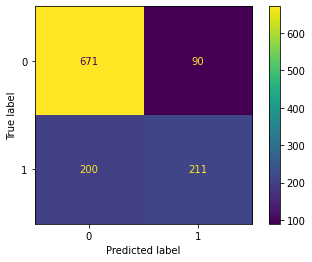

In [ ]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced")
rf.fit(x_train, y_train)
print("Test accuracy: ",accuracy_score(y_test, rf.predict(x_test)))
ConfusionMatrixDisplay(confusion_matrix(y_test, rf.predict(x_test))).plot()